In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml 

# Load & prepare web logs (dw)

# 1. Extract the web log ZIP file
# 2. Load all .txt files and concatenate into dw
# 3. Merge Variation (Test/Control) from experiment file
# 4. Merge client age from demo file

# Paths to input files
# ZIP_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_web_data_pt_.zip"
# EXPERIMENT_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_experiment_clients.txt"
# DEMO_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_demo.txt"
# EXTRACT_DIR = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/webdata_extracted"

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

EXP_PATH = config['input_data']['file2']
DEMO_PATH = config['input_data']['file1']
ZIP_PATH  = config['input_data']['file5']
EXTRACT_DIR = "../data/raw/rawwebdata_extracted"


# Extract ZIP
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# Load and concatenate all .txt files
web_files = [f for f in os.listdir(EXTRACT_DIR) if f.endswith(".txt")]
frames = [
    pd.read_csv(os.path.join(EXTRACT_DIR, f), parse_dates=["date_time"]) 
    for f in web_files
]
dw = pd.concat(frames, ignore_index=True)
print(f"✅ Loaded web logs: {len(dw):,} rows from {len(web_files)} files")
print("Columns in dw (before merge):", dw.columns.tolist())

# Merge Variation (CSV file)
exp_clients = pd.read_csv(EXP_PATH, sep=",")
print("Columns in exp_clients:", exp_clients.columns.tolist())
exp_clients = exp_clients[["client_id", "Variation"]]
dw = dw.merge(exp_clients, on="client_id", how="inner")
print(f"✅ Variation merged. Unique groups: {dw['Variation'].unique()}")

# Merge client age (CSV file)

df_demo = pd.read_csv(DEMO_PATH, sep=",")
print("Columns in df_demo:", df_demo.columns.tolist())
df_demo = df_demo[["client_id", "clnt_age"]]
dw = dw.merge(df_demo, on="client_id", how="left")
print(f"✅ Age merged. Non-null ages: {dw['clnt_age'].notna().sum():,}")
print("Columns in dw (final):", dw.columns.tolist()[:10], "...")
print(dw.head(3))


✅ Loaded web logs: 755,405 rows from 2 files
Columns in dw (before merge): ['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time']
Columns in exp_clients: ['client_id', 'Variation']
✅ Variation merged. Unique groups: ['Test' 'Control' nan]
Columns in df_demo: ['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']
✅ Age merged. Non-null ages: 449,704
Columns in dw (final): ['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time', 'Variation', 'clnt_age'] ...
   client_id            visitor_id                      visit_id process_step  \
0    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   
1    9988021  580560515_7732621733  781255054_21935453173_531117       step_2   
2    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   

            date_time Variation  clnt_age  
0 2017-04-17 15:27:07      Test      79.0  
1 2017-04-17 15:26:51      Tes

In [3]:
# 1: Define process step order

# Map each step to a numeric order, so we can detect when a user moves BACKWARD (from step_2 to step_1).

step_order = {
    "start": 0,
    "step_1": 1,
    "step_2": 2,
    "step_3": 3,
    "confirm": 4
}

In [4]:
# 2: Function to count backward moves per visit

# For each visit (visit_id):
# 1. Sort events by date_time
# 2. Map steps to numeric order
# 3. Count decreases in the sequence (backward moves)

def count_backward_moves(df_visit):
    df_visit = df_visit.sort_values("date_time")
    step_nums = df_visit["process_step"].map(step_order).dropna().tolist()
    backward_moves = sum(
        1 for i in range(1, len(step_nums)) if step_nums[i] < step_nums[i - 1]
    )
    return backward_moves

In [ ]:
# 3: Count backward moves for each visit

# Group by visit_id and Variation (Test/Control) to count how many backward moves each visit has.

error_counts = (
    dw.groupby(["visit_id", "Variation"])
    .apply(count_backward_moves, include_groups=False)
    .reset_index(name="num_backward_moves")
)

# whether the visit had at least one backward move
# error_counts_age["had_error"] = error_counts_age["num_backward_moves"] > 0
error_counts["had_error"] = error_counts["num_backward_moves"] > 0

In [6]:
# 4: Error rate summary by group

# - Average number of backward moves per visit
# - Share of visits with at least one backward move

# Average number of backward moves per visit
error_rate_by_group = (
    error_counts.groupby("Variation")["num_backward_moves"]
    .mean()
    .reset_index(name="avg_backward_moves_per_visit")
)

# Share of visits with at least one backward move
error_counts["had_error"] = error_counts["num_backward_moves"] > 0
error_share_by_group = (
    error_counts.groupby("Variation")["had_error"]
    .mean()
    .reset_index(name="share_visits_with_error")
)

print("=== Error rate summary by group (Test vs Control) ===")
display(error_rate_by_group)
display(error_share_by_group)

=== Error rate summary by group (Test vs Control) ===


,Variation,avg_backward_moves_per_visit
0,Control,0.300196
1,Test,0.439170


,Variation,share_visits_with_error
0,Control,0.204449
1,Test,0.269523


In [7]:
# 5: Add age bands for age-based analysis

# Assign each visit an age band based on clnt_age.

bins = list(range(10, 101, 10))
labels = [f"{i}-{i+9}" for i in bins[:-1]]

# Create mapping of visit_id -> age_band
age_map = (
    dw[["visit_id", "clnt_age"]]
    .drop_duplicates()
    .assign(age_band=lambda d: pd.cut(d["clnt_age"], bins=bins, labels=labels, right=False))
)

# Merge age band into error counts
error_counts_age = error_counts.merge(age_map, on="visit_id", how="left")

In [8]:
# 6: Error rate by age band & group — with formatted outputs

# For each (Variation, age_band):
# - Average number of backward moves per visit
# - Share of visits with at least one backward move

error_rate_by_age = (
    error_counts_age.groupby(["Variation", "age_band"], observed=True)["num_backward_moves"]
    .mean()
    .reset_index(name="avg_backward_moves_per_visit")
)

error_share_by_age = (
    error_counts_age.groupby(["Variation", "age_band"], observed=True)["had_error"]
    .mean()
    .reset_index(name="share_visits_with_error")
)

# Merge the two summaries for convenience
error_summary_by_age = error_rate_by_age.merge(
    error_share_by_age,
    on=["Variation", "age_band"],
    how="left"
)

# --- Formatting section ---
# Round numeric values for analysis
error_summary_by_age["avg_backward_moves_per_visit"] = (
    error_summary_by_age["avg_backward_moves_per_visit"].round(3)
)
error_summary_by_age["share_visits_with_error"] = (
    error_summary_by_age["share_visits_with_error"].round(3)
)

# Add formatted string columns for display
error_summary_by_age["avg_backward_moves_per_visit_fmt"] = (
    error_summary_by_age["avg_backward_moves_per_visit"]
    .apply(lambda x: f"{x*100:.1f}%")
)

error_summary_by_age["share_visits_with_error_fmt"] = (
    error_summary_by_age["share_visits_with_error"]
    .apply(lambda x: f"{x*100:.1f}%")
)

# --- Final display ---
print("=== Error Summary by Age Band & Group ===")
display(error_summary_by_age)


=== Error Summary by Age Band & Group ===


,Variation,age_band,avg_backward_moves_per_visit,share_visits_with_error,avg_backward_moves_per_visit_fmt,share_visits_with_error_fmt
0,Control,10-19,0.324,0.197,32.4%,19.7%
1,Control,20-29,0.303,0.221,30.3%,22.1%
2,Control,30-39,0.265,0.192,26.5%,19.2%
3,Control,40-49,0.289,0.200,28.9%,20.0%
4,Control,50-59,0.315,0.209,31.5%,20.9%
5,Control,60-69,0.322,0.210,32.2%,21.0%
6,Control,70-79,0.314,0.194,31.4%,19.4%
7,Control,80-89,0.329,0.204,32.9%,20.4%
8,Control,90-99,0.395,0.263,39.5%,26.3%
9,Test,10-19,0.348,0.250,34.8%,25.0%


In [9]:
# 7: Plot error metrics by age band & group (Test vs Control)

import matplotlib.pyplot as plt
import numpy as np

def plot_error_metric(df, value_col, title, ylabel):
    """
    Plot a grouped bar chart for the given error metric.
    - df: error_summary_by_age DataFrame
    - value_col: name of the numeric column to plot
    - title: plot title
    - ylabel: y-axis label
    """
    # Pivot to have Test & Control as columns, age_band as index
    pivot = df.pivot(index="age_band", columns="Variation", values=value_col)
    pivot = pivot.reindex(index=sorted(pivot.index, key=lambda x: str(x)))  # ensure age order

    x = np.arange(len(pivot.index))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, pivot["Test"], width, label="Test")
    ax.bar(x + width/2, pivot["Control"], width, label="Control")

    ax.set_xlabel("Age band")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()


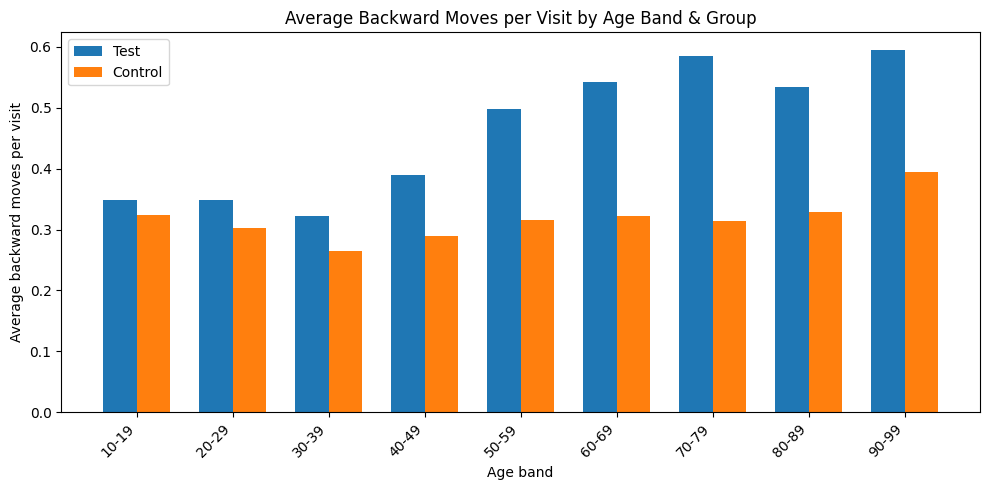

In [10]:
# --- Plot 1: Average backward moves per visit ---
plot_error_metric(
    error_summary_by_age,
    "avg_backward_moves_per_visit",
    "Average Backward Moves per Visit by Age Band & Group",
    "Average backward moves per visit"
)

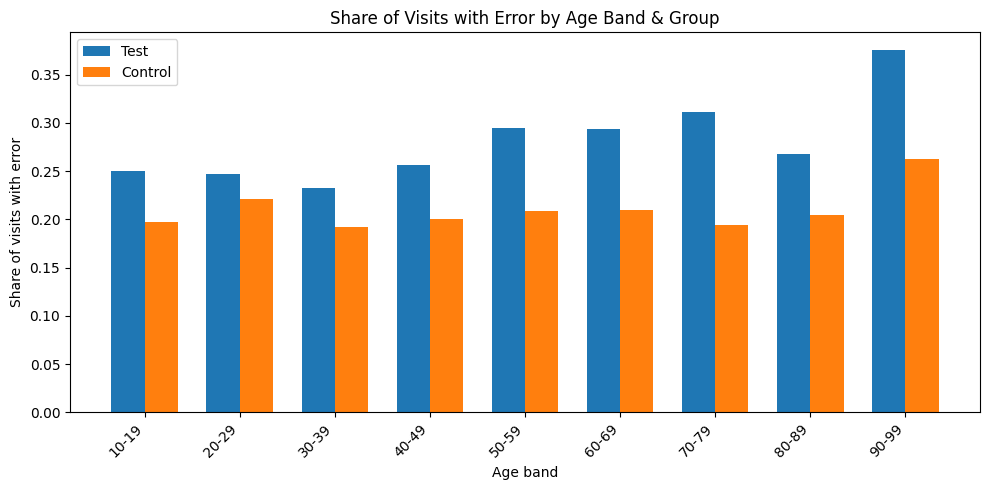

In [62]:
# --- Plot 2: Share of visits with at least one backward move ---
plot_error_metric(
    error_summary_by_age,
    "share_visits_with_error",
    "Share of Visits with Error by Age Band & Group",
    "Share of visits with error"
)